In [1]:
!pip install segmentation_models_pytorch


  Obtaining dependency information for segmentation_models_pytorch from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
  Obtaining dependency information for timm==0.9.2 from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 6.6 MB/s eta 0:00:00
  Obtaining dependency information for munch from https://files.pythonhosted.org/packages/56/b3/7c69b37f03260a061883bec0e7b05be7117c1b1c85f5212c72c8c2bc3c8c/munch-4.0.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

# Importing  libararies

In [2]:
# Importing the libraries and pytorch
import json
import os
import torch
import cv2
import numpy as np
import albumentations as A
from PIL import Image
from matplotlib import pyplot as plt
from glob import glob
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import random
import torchvision.transforms as T
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
#import tensorboard for pytorch
from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler
tensorboard_writer = SummaryWriter()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Prepare the data

this custom dataset load the data and apply transformation to it

In [3]:
class CustomSegmentationDataset(Dataset):
    def __init__(self, transformations=None):
        self.im_paths = sorted(glob("/kaggle/input/uploud/*.jpg"))
        self.mask_paths = [im_path for im_path in sorted(glob("/kaggle/input/uploud/*.png")) if "fuse" in im_path]
        self.transformations = transformations
        self.n_cls = 11
        assert len(self.im_paths) == len(self.mask_paths)

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im, mask = self.get_im_mask(self.im_paths[idx], self.mask_paths[idx])
        if self.transformations:
            im, mask = self.apply_transformations(im, mask)
        return im, mask

    def get_im_mask(self, im_path, mask_path):
        return self.read_im(im_path), self.read_im(mask_path)

    def read_im(self, path):
        return cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

    def apply_transformations(self, im, mask):
        transformed = self.transformations(image=im, mask=mask)
        return transformed["image"], transformed["mask"]


In [4]:
# Cell 3: Define the get_dls function
def get_data_loaders(transformations, batch_size, split=[0.9, 0.05, 0.05]):
    assert sum(split) == 1., "Sum of the split must be exactly 1"
    ds = CustomSegmentationDataset(transformations=transformations)
    n_cls = ds.n_cls

    tr_len = int(len(ds) * split[0])
    val_len = int(len(ds) * split[1])
    test_len = len(ds) - (tr_len + val_len)

    # Data split
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])

    print(f"\nThere are {len(tr_ds)} number of images in the train set")
    print(f"There are {len(val_ds)} number of images in the validation set")
    print(f"There are {len(test_ds)} number of images in the test set\n")

    # Get dataloaders
    data_loaders= {
        "train": DataLoader(tr_ds, batch_size=batch_size, shuffle=True),
        "valid": DataLoader(val_ds, batch_size=batch_size, shuffle=False),
        "test": DataLoader(test_ds, batch_size=1, shuffle=False)}
    return data_loaders, n_cls

In [5]:
# Cell 4: Define constants and transformations
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
trans = A.Compose([
    A.Resize(320, 320),
    A.augmentations.transforms.Normalize(mean=mean, std=std),
    ToTensorV2(transpose_mask=True)
])

In [6]:
data_loaders, n_cls = get_data_loaders(transformations=trans, batch_size=4)



There are 90 number of images in the train set
There are 5 number of images in the validation set
There are 5 number of images in the test set



# Data visualization

In [7]:
import random

def tensor_to_numpy(t):
    inv_trans = T.Compose([
        T.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
    ])

    rgb = True if len(t) == 3 else False

    return (inv_trans(t) * 255).detach().cpu().permute(1, 2, 0).numpy().astype(np.uint8) if rgb else (t*255).detach().cpu().numpy().astype(np.uint8)

def plot_image(rows, cols, count, image,mask=True,title="Original Image"):
    plt.subplot(rows, cols, count)
    plt.imshow(tensor_to_numpy(image.squeeze(0).float())) if mask else plt.imshow(tn_2_np(image.squeeze(0))) 
    plt.axis("off")
    plt.title(title)
    return count + 1

def visualize_dataset(dataset, num_images):
    plt.figure(figsize=(25, 20))
    rows = num_images // 4
    cols = num_images // rows
    count = 1
    indices = [random.randint(0, len(dataset) - 1) for _ in range(num_images)]

    for idx, index in enumerate(indices):
        if count == num_images + 1:
            break
        image, ground_truth = dataset[index]

        # First Plot
        count = plot_image(rows, cols, count, image)

        # Second Plot
        count = plot_image(rows, cols, count, image=ground_truth, title="Ground Truth")

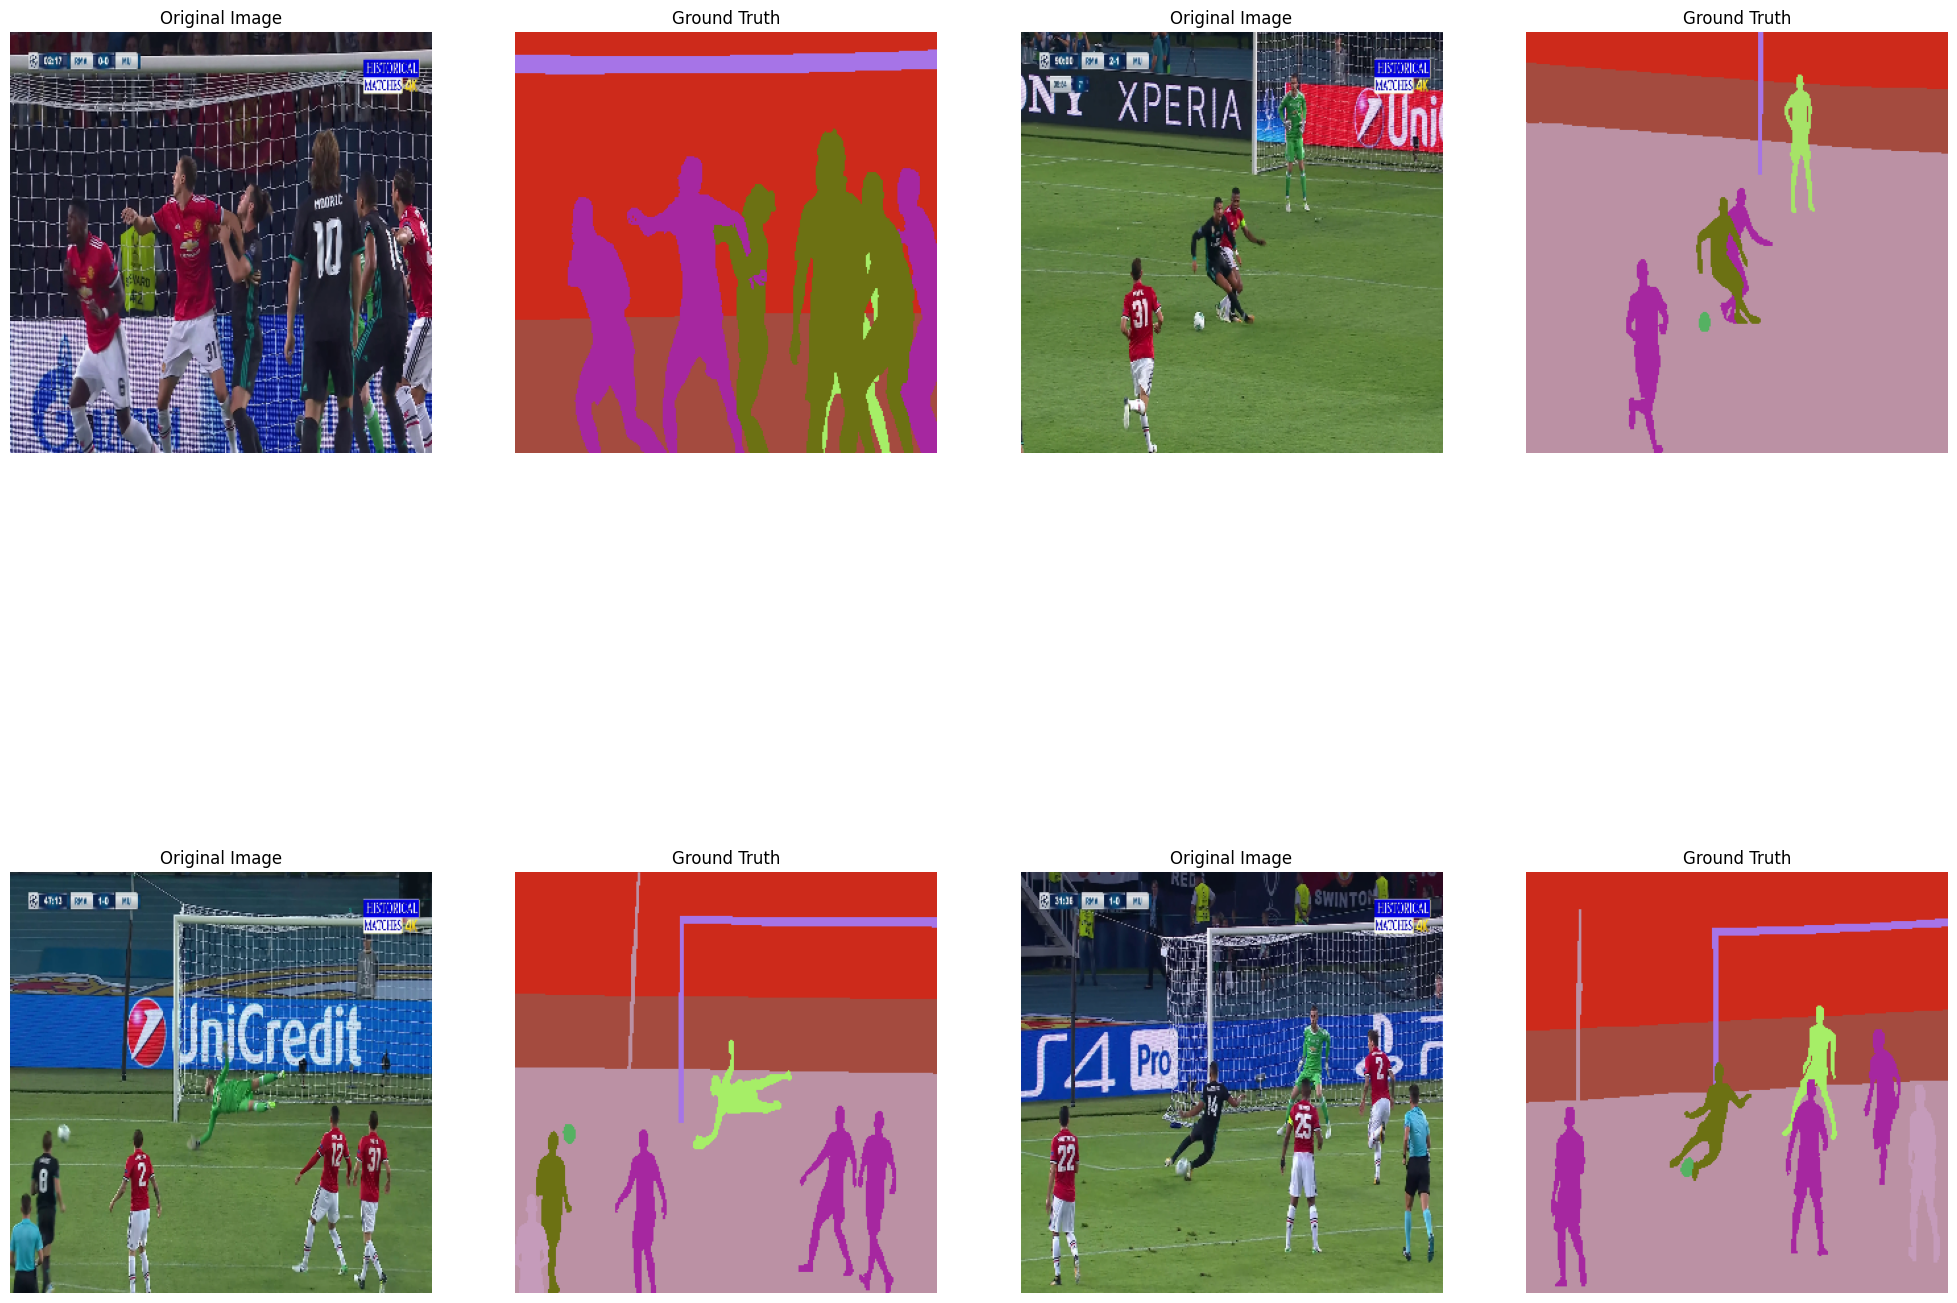

In [8]:
visualize_dataset(data_loaders['train'].dataset, num_images=8)


# Loading the model and create the optimizer

In [9]:
model = smp.Unet(classes=n_cls)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 225MB/s]


In [10]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(),lr=0.0001)


# Make the training functions

In [11]:
class Metrics:
    def __init__(self, pred, mask, loss_fn, eps=1e-10, n_cls=2):
        # Convert raw predictions to class indices using softmax
        self.pred = torch.argmax(F.softmax(pred, dim=1), dim=1)
        self.mask = mask  # Ground truth labels
        self.loss_fn = loss_fn
        self.eps = eps
        self.n_cls = n_cls
        self.pred_ = pred 

    def to_contiguous(self, inp):
        return inp.contiguous().view(-1)

    def calculate_match(self, tensor1, tensor2):
        # Calculate element-wise equality between two tensors
        return torch.eq(tensor1, tensor2).int()

    def PA(self):
        with torch.no_grad():
            # Calculate element-wise equality between predictions and ground truth
            match = self.calculate_match(self.pred, self.mask)
        
        return float(match.sum()) / float(match.numel())

    def mIoU(self):
        with torch.no_grad():
            # Convert ground truth to class indices
            self.mask = torch.argmax(self.mask, dim=1)

            pred, mask = self.to_contiguous(self.pred), self.to_contiguous(self.mask)

            iou_per_class = []

            for c in range(self.n_cls):
                match_pred = pred == c
                match_mask = mask == c

                if match_mask.long().sum().item() == 0:
                    iou_per_class.append(np.nan)
                else:
                    intersect = torch.logical_and(match_pred, match_mask).sum().float().item()
                    union = torch.logical_or(match_pred, match_mask).sum().float().item()

                    iou = (intersect + self.eps) / (union + self.eps)
                    iou_per_class.append(iou)

            return np.nanmean(iou_per_class)

    def loss(self):
        # Calculate the loss using the provided loss function
        return self.loss_fn(self.pred_, torch.argmax(self.mask, dim=1))


In [12]:
def train(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, epochs):
    train_losses, train_pa, train_iou = [], [], []
    val_losses, val_pa, val_iou = [], [], []
    train_length, val_length = len(train_dataloader), len(val_dataloader)
    model.to(device)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    

    for epoch in range(1, epochs + 1):
        epoch_train_loss, epoch_train_iou, epoch_train_pa = 0, 0, 0
      
        model.train()
        print(f"Epoch {epoch} - Training process is started...")
        

        # Initialize tqdm with dynamic loss display
        train_progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for batch_idx, (images, targets) in train_progress_bar:
            images, targets = images.to(device), targets.to(device)

            # Forward pass
            optimizer.zero_grad()
            predictions = model(images)

            # Calculate metrics
            metrics = Metrics(predictions, targets, loss_fn, n_cls=n_cls)
            loss = metrics.loss()
            epoch_train_iou += metrics.mIoU()
            epoch_train_pa += metrics.PA()
            epoch_train_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            

            # Update tqdm with live loss display
            train_progress_bar.set_postfix({"Train Loss": loss.item()}, refresh=True)
            

        # Calculate average metrics for the training epoch
        epoch_train_loss /= train_length
        epoch_train_iou /=train_length
        epoch_train_pa /=train_length
        
        print(f"Epoch {epoch} train loss is {epoch_train_loss}  train PA is {epoch_train_pa} train mIoU is {epoch_train_iou}")


        # Log metrics to TensorBoard for training phase
        tensorboard_writer.add_scalar('Train Loss', epoch_train_loss, epoch)
        tensorboard_writer.add_scalar('Train PA', epoch_train_iou, epoch)
        tensorboard_writer.add_scalar('Train mIoU', epoch_train_pa, epoch)

        valid_loss_min = None
        epoch_val_loss, epoch_val_iou, epoch_val_pa = 0, 0, 0
        valid_progress_bar = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
        for batch_idx, (val_images, val_targets) in valid_progress_bar:
            # Move tensors to device
            val_images, val_targets = val_images.to(device), val_targets.to(device)
            model.eval()
             
            # Forward pass for validation
            with torch.no_grad():
                val_predictions = model(val_images)
            
            # Calculate metrics for validation
            val_metrics = Metrics(val_predictions, val_targets, loss_fn, n_cls=n_cls)
            validation_loss = val_metrics.loss()
            
            
            epoch_val_loss+=validation_loss.item()
            if valid_loss_min is None or (
            (valid_loss_min - epoch_val_loss) / valid_loss_min > 0.01
        ):
                print(f"New minimum validation loss: {epoch_val_loss:.6f}. Saving model ...")

               # Save the weights to save_path
                torch.save(model, 'model.pth')

                valid_loss_min = epoch_val_loss

        # Update learning rate, i.e., make a step in the learning rate scheduler
            scheduler.step()
            
            
            epoch_val_iou+=val_metrics.mIoU()
            epoch_val_pa+=val_metrics.PA()
            
            epoch_val_loss /= val_length
            epoch_val_iou /= val_length
            epoch_val_pa /= val_length
            
            # Update tqdm with live loss display
            valid_progress_bar.set_postfix({"Validation Loss": validation_loss.item()}, refresh=True)
          
        
            
        # Log metrics to TensorBoard for validation phase
        tensorboard_writer.add_scalar('Validation Loss',epoch_val_loss, epoch)
        tensorboard_writer.add_scalar('Validation PA', epoch_val_pa, epoch)
        tensorboard_writer.add_scalar('Validation mIoU',  epoch_val_iou, epoch)
        print(f"Epoch {epoch} validation loss is {epoch_val_loss}  validation PA is {epoch_val_pa} validation mIoU is {epoch_val_iou}")


    # Close TensorBoard writer
    tensorboard_writer.close()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the data

In [13]:
train(model=model, train_dataloader=data_loaders['train'], val_dataloader=data_loaders['valid'],
                 loss_fn=loss, optimizer=optimizer, device=device,
                 epochs=60)


Epoch 1 - Training process is started...


100%|██████████| 23/23 [00:11<00:00,  1.93it/s, Train Loss=2.6]


Epoch 1 train loss is 2.62657412238743  train PA is 0.04190503991168478 train mIoU is 0.038224103876820834


 50%|█████     | 1/2 [00:00<00:00,  2.46it/s, Validation Loss=2.54]

New minimum validation loss: 2.539661. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.98it/s, Validation Loss=2.59]


Epoch 1 validation loss is 1.9275029301643372  validation PA is 0.0285711669921875 validation mIoU is 0.026539006338227963
Epoch 2 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.28it/s, Train Loss=2.53]


Epoch 2 train loss is 2.598880923312643  train PA is 0.04677925441576086 train mIoU is 0.042592227352548605


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.545310. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.12it/s, Validation Loss=2.61]


Epoch 2 validation loss is 1.9399327039718628  validation PA is 0.037320556640625 validation mIoU is 0.03408493598857121
Epoch 3 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.35it/s, Train Loss=2.61]


Epoch 3 train loss is 2.5721066723699155  train PA is 0.05208060886548914 train mIoU is 0.04747118941604032


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.528523. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.24it/s, Validation Loss=2.61]


Epoch 3 validation loss is 1.9379262328147888  validation PA is 0.040180053710937504 validation mIoU is 0.03666124292483616
Epoch 4 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.27it/s, Train Loss=2.55]


Epoch 4 train loss is 2.5474363824595576  train PA is 0.0579658840013587 train mIoU is 0.05276494450733993


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.500223. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.14it/s, Validation Loss=2.56]


Epoch 4 validation loss is 1.9044710993766785  validation PA is 0.04689758300781249 validation mIoU is 0.04264890063426333
Epoch 5 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.38it/s, Train Loss=2.57]


Epoch 5 train loss is 2.5202954437421714  train PA is 0.06458039656929347 train mIoU is 0.05821973936314439


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.468150. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.49it/s, Validation Loss=2.57]


Epoch 5 validation loss is 1.9033620357513428  validation PA is 0.0497674560546875 validation mIoU is 0.04498658077108762
Epoch 6 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.35it/s, Train Loss=2.51]


Epoch 6 train loss is 2.5017682676729947  train PA is 0.06848378057065217 train mIoU is 0.06155583600765289


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.468590. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.16it/s, Validation Loss=2.53]


Epoch 6 validation loss is 1.8817448616027832  validation PA is 0.0537994384765625 validation mIoU is 0.048648582111667005
Epoch 7 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.31it/s, Train Loss=2.47]


Epoch 7 train loss is 2.4976161251897397  train PA is 0.07011453379755436 train mIoU is 0.06301704502558422


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.472722. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.55it/s, Validation Loss=2.57]


Epoch 7 validation loss is 1.9012004137039185  validation PA is 0.0510577392578125 validation mIoU is 0.04619385337787546
Epoch 8 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.36it/s, Train Loss=2.49]


Epoch 8 train loss is 2.5001365827477495  train PA is 0.06964015794836959 train mIoU is 0.06262100139391297


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.469266. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.09it/s, Validation Loss=2.55]


Epoch 8 validation loss is 1.8904983401298523  validation PA is 0.05264892578125 validation mIoU is 0.04761668553287823
Epoch 9 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.34it/s, Train Loss=2.49]


Epoch 9 train loss is 2.4961784196936567  train PA is 0.07061778192934781 train mIoU is 0.06318197085381215


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.465507. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.24it/s, Validation Loss=2.53]


Epoch 9 validation loss is 1.880812406539917  validation PA is 0.053105468749999996 validation mIoU is 0.047990373387663515
Epoch 10 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.40it/s, Train Loss=2.53]


Epoch 10 train loss is 2.4955673010452935  train PA is 0.07122229534646739 train mIoU is 0.06368188953987697


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.469216. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.56it/s, Validation Loss=2.54]


Epoch 10 validation loss is 1.8877279162406921  validation PA is 0.0529010009765625 validation mIoU is 0.04772796401087022
Epoch 11 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.44it/s, Train Loss=2.45]


Epoch 11 train loss is 2.489478214927342  train PA is 0.07209578804347826 train mIoU is 0.06462591652503659


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.454856. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.40it/s, Validation Loss=2.52]


Epoch 11 validation loss is 1.8728910684585571  validation PA is 0.054239501953125005 validation mIoU is 0.04885956796906259
Epoch 12 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.42it/s, Train Loss=2.48]


Epoch 12 train loss is 2.492170831431513  train PA is 0.0713130519701087 train mIoU is 0.06397383393621174


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.477457. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Validation Loss=2.52]


Epoch 12 validation loss is 1.8775694370269775  validation PA is 0.0551275634765625 validation mIoU is 0.04991785745510666
Epoch 13 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.47it/s, Train Loss=2.5]


Epoch 13 train loss is 2.4924895763397217  train PA is 0.07165771484375001 train mIoU is 0.06415666334987453


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.471673. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.64it/s, Validation Loss=2.54]


Epoch 13 validation loss is 1.8895648121833801  validation PA is 0.05279296875 validation mIoU is 0.0477110790196998
Epoch 14 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.41it/s, Train Loss=2.5]


Epoch 14 train loss is 2.492015320321788  train PA is 0.07179783033288044 train mIoU is 0.06432870185881412


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.471030. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Validation Loss=2.52]


Epoch 14 validation loss is 1.8756093978881836  validation PA is 0.055260620117187506 validation mIoU is 0.04995589531235141
Epoch 15 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.38it/s, Train Loss=2.5]


Epoch 15 train loss is 2.4921675972316577  train PA is 0.07190886124320653 train mIoU is 0.06472646413261095


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.462584. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.53it/s, Validation Loss=2.52]


Epoch 15 validation loss is 1.874443769454956  validation PA is 0.0556793212890625 validation mIoU is 0.05030735263684806
Epoch 16 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.40it/s, Train Loss=2.44]


Epoch 16 train loss is 2.4875998807990034  train PA is 0.07266718325407609 train mIoU is 0.06521773358962976


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.472208. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Validation Loss=2.54]


Epoch 16 validation loss is 1.886758804321289  validation PA is 0.0525506591796875 validation mIoU is 0.047377551690511124
Epoch 17 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.36it/s, Train Loss=2.53]


Epoch 17 train loss is 2.492777741473654  train PA is 0.07122802734374999 train mIoU is 0.06392288434499291


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.461300. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.65it/s, Validation Loss=2.55]


Epoch 17 validation loss is 1.8924654126167297  validation PA is 0.053994140625 validation mIoU is 0.048692190356025795
Epoch 18 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.39it/s, Train Loss=2.5]


Epoch 18 train loss is 2.4886040065599526  train PA is 0.07222730553668477 train mIoU is 0.06478509734177447


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.471545. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.40it/s, Validation Loss=2.51]


Epoch 18 validation loss is 1.8753029704093933  validation PA is 0.0550244140625 validation mIoU is 0.049749777566069076
Epoch 19 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.44it/s, Train Loss=2.56]


Epoch 19 train loss is 2.490497454353001  train PA is 0.07216871178668477 train mIoU is 0.0645409682993025


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.457593. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.20it/s, Validation Loss=2.52]


Epoch 19 validation loss is 1.8760327696800232  validation PA is 0.0550115966796875 validation mIoU is 0.04978170952411596
Epoch 20 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.46it/s, Train Loss=2.5]


Epoch 20 train loss is 2.490211766699086  train PA is 0.07214100713315216 train mIoU is 0.06486768584314392


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.461858. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.40it/s, Validation Loss=2.52]


Epoch 20 validation loss is 1.8775107860565186  validation PA is 0.0549560546875 validation mIoU is 0.04963150427861106
Epoch 21 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.33it/s, Train Loss=2.48]


Epoch 21 train loss is 2.4910512074180273  train PA is 0.07255052649456521 train mIoU is 0.06487559750373524


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.464617. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.55it/s, Validation Loss=2.53]


Epoch 21 validation loss is 1.880107820034027  validation PA is 0.053823852539062494 validation mIoU is 0.04859053904349368
Epoch 22 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.45it/s, Train Loss=2.54]


Epoch 22 train loss is 2.4910869805709175  train PA is 0.07191193953804349 train mIoU is 0.06462137943239431


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.460007. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.17it/s, Validation Loss=2.52]


Epoch 22 validation loss is 1.8765400648117065  validation PA is 0.054578857421875 validation mIoU is 0.049273447041878
Epoch 23 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.42it/s, Train Loss=2.46]


Epoch 23 train loss is 2.4911507523578145  train PA is 0.07194834833559781 train mIoU is 0.06421586251962436


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.458122. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.40it/s, Validation Loss=2.51]


Epoch 23 validation loss is 1.86737859249115  validation PA is 0.0562774658203125 validation mIoU is 0.05089413930896487
Epoch 24 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.44it/s, Train Loss=2.49]


Epoch 24 train loss is 2.4891227431919263  train PA is 0.072158203125 train mIoU is 0.06482473370136085


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.468748. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.58it/s, Validation Loss=2.53]


Epoch 24 validation loss is 1.8836174011230469  validation PA is 0.055195922851562496 validation mIoU is 0.049830343072734276
Epoch 25 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.41it/s, Train Loss=2.47]


Epoch 25 train loss is 2.4891218828118364  train PA is 0.07246879245923912 train mIoU is 0.06494630825108891


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.465844. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Validation Loss=2.53]


Epoch 25 validation loss is 1.8791314363479614  validation PA is 0.05565673828125001 validation mIoU is 0.050245799137214386
Epoch 26 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.30it/s, Train Loss=2.55]


Epoch 26 train loss is 2.492334282916525  train PA is 0.07142578125 train mIoU is 0.06423492582431532


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.455765. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Validation Loss=2.52]


Epoch 26 validation loss is 1.871939480304718  validation PA is 0.055352783203125006 validation mIoU is 0.04991767302564626
Epoch 27 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.36it/s, Train Loss=2.48]


Epoch 27 train loss is 2.4906274754068125  train PA is 0.07200853430706522 train mIoU is 0.06449526295946258


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.463055. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Validation Loss=2.52]


Epoch 27 validation loss is 1.876272737979889  validation PA is 0.0544427490234375 validation mIoU is 0.04918853507676107
Epoch 28 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.34it/s, Train Loss=2.52]


Epoch 28 train loss is 2.4931506695954697  train PA is 0.07184113875679349 train mIoU is 0.06442513374484231


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.475143. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.87it/s, Validation Loss=2.55]


Epoch 28 validation loss is 1.8918231129646301  validation PA is 0.0517742919921875 validation mIoU is 0.04676332516026581
Epoch 29 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.32it/s, Train Loss=2.5]


Epoch 29 train loss is 2.4956729930380117  train PA is 0.07075343919836956 train mIoU is 0.0633613715889666


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.469585. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.88it/s, Validation Loss=2.54]


Epoch 29 validation loss is 1.8867093920707703  validation PA is 0.054951171875 validation mIoU is 0.049717059573000655
Epoch 30 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.30it/s, Train Loss=2.51]


Epoch 30 train loss is 2.490704754124517  train PA is 0.0721952488111413 train mIoU is 0.06472526557896933


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.456759. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.39it/s, Validation Loss=2.52]


Epoch 30 validation loss is 1.8751600980758667  validation PA is 0.05498046875 validation mIoU is 0.049507185054915345
Epoch 31 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.40it/s, Train Loss=2.48]


Epoch 31 train loss is 2.4901670373004414  train PA is 0.07200216542119564 train mIoU is 0.06475471339044811


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.467841. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.18it/s, Validation Loss=2.51]


Epoch 31 validation loss is 1.8730850219726562  validation PA is 0.05563232421875 validation mIoU is 0.050298164515797376
Epoch 32 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.35it/s, Train Loss=2.57]


Epoch 32 train loss is 2.4908158260843027  train PA is 0.07163468070652172 train mIoU is 0.06405859079242614


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.454298. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.42it/s, Validation Loss=2.51]


Epoch 32 validation loss is 1.8696698546409607  validation PA is 0.056185302734375005 validation mIoU is 0.050686271095355506
Epoch 33 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.37it/s, Train Loss=2.52]


Epoch 33 train loss is 2.4937693969063135  train PA is 0.07128513502038043 train mIoU is 0.06393643409521796


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.462997. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.54it/s, Validation Loss=2.54]


Epoch 33 validation loss is 1.8873364925384521  validation PA is 0.053096923828125 validation mIoU is 0.047847676536112646
Epoch 34 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.38it/s, Train Loss=2.45]


Epoch 34 train loss is 2.4889134946076767  train PA is 0.07241147248641304 train mIoU is 0.0650953479948428


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.465801. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Validation Loss=2.51]


Epoch 34 validation loss is 1.872002899646759  validation PA is 0.05647216796875 validation mIoU is 0.051088834551981877
Epoch 35 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.39it/s, Train Loss=2.49]


Epoch 35 train loss is 2.4905402245728867  train PA is 0.07220289147418478 train mIoU is 0.06481489281263533


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.461405. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.55it/s, Validation Loss=2.51]


Epoch 35 validation loss is 1.8709311485290527  validation PA is 0.0568707275390625 validation mIoU is 0.051435837373741744
Epoch 36 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.41it/s, Train Loss=2.51]


Epoch 36 train loss is 2.4919232181880786  train PA is 0.07198093580163045 train mIoU is 0.06430815019957878


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.465393. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Validation Loss=2.52]


Epoch 36 validation loss is 1.8767595887184143  validation PA is 0.054705810546875 validation mIoU is 0.0494319516735211
Epoch 37 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.38it/s, Train Loss=2.46]


Epoch 37 train loss is 2.4886829542077105  train PA is 0.07262069038722825 train mIoU is 0.06488520981453198


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.465051. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.56it/s, Validation Loss=2.53]


Epoch 37 validation loss is 1.8790735006332397  validation PA is 0.054190673828124994 validation mIoU is 0.049039488924534844
Epoch 38 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.42it/s, Train Loss=2.45]


Epoch 38 train loss is 2.4904572652733843  train PA is 0.07191469938858694 train mIoU is 0.06435215179579833


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.454172. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.00it/s, Validation Loss=2.51]


Epoch 38 validation loss is 1.8692114353179932  validation PA is 0.05698242187500001 validation mIoU is 0.05136363127056755
Epoch 39 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.37it/s, Train Loss=2.47]


Epoch 39 train loss is 2.4928223050158955  train PA is 0.07160867442255435 train mIoU is 0.06396563733584715


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.461180. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.38it/s, Validation Loss=2.52]


Epoch 39 validation loss is 1.8753060102462769  validation PA is 0.05543701171875 validation mIoU is 0.04983583510589544
Epoch 40 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.33it/s, Train Loss=2.46]


Epoch 40 train loss is 2.488153882648634  train PA is 0.07261442764945654 train mIoU is 0.06484396672190056


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.462121. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.91it/s, Validation Loss=2.53]


Epoch 40 validation loss is 1.8818395733833313  validation PA is 0.054645996093749996 validation mIoU is 0.04929352930221764
Epoch 41 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.40it/s, Train Loss=2.53]


Epoch 41 train loss is 2.4919429654660434  train PA is 0.07201161260190218 train mIoU is 0.06477297407109756


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.459482. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.44it/s, Validation Loss=2.53]


Epoch 41 validation loss is 1.8798415660858154  validation PA is 0.05365966796875 validation mIoU is 0.04837110001757898
Epoch 42 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.28it/s, Train Loss=2.52]


Epoch 42 train loss is 2.491096475849981  train PA is 0.07271049167798913 train mIoU is 0.06513405032125284


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.471023. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.43it/s, Validation Loss=2.54]


Epoch 42 validation loss is 1.8879802227020264  validation PA is 0.053450927734375 validation mIoU is 0.04828335949603941
Epoch 43 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.42it/s, Train Loss=2.48]


Epoch 43 train loss is 2.48985160952029  train PA is 0.07262164572010868 train mIoU is 0.06503032352764371


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.463606. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.51it/s, Validation Loss=2.53]


Epoch 43 validation loss is 1.881684422492981  validation PA is 0.053128662109375 validation mIoU is 0.04791178448305167
Epoch 44 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.34it/s, Train Loss=2.53]


Epoch 44 train loss is 2.4910524617070737  train PA is 0.07202339504076086 train mIoU is 0.06485112109588599


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.448810. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.40it/s, Validation Loss=2.54]


Epoch 44 validation loss is 1.883925199508667  validation PA is 0.0539886474609375 validation mIoU is 0.0484662014089718
Epoch 45 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.33it/s, Train Loss=2.48]


Epoch 45 train loss is 2.488477209339971  train PA is 0.07237601902173914 train mIoU is 0.06519802003554476


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.460083. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Validation Loss=2.53]


Epoch 45 validation loss is 1.8797724843025208  validation PA is 0.055086669921875 validation mIoU is 0.04980860979564728
Epoch 46 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.36it/s, Train Loss=2.55]


Epoch 46 train loss is 2.492955798688142  train PA is 0.0718086574388587 train mIoU is 0.06436491895813094


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.454728. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.40it/s, Validation Loss=2.54]


Epoch 46 validation loss is 1.8856850266456604  validation PA is 0.0538726806640625 validation mIoU is 0.04861277715147334
Epoch 47 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.35it/s, Train Loss=2.49]


Epoch 47 train loss is 2.487647854763529  train PA is 0.07279158882472825 train mIoU is 0.06567088882591009


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.469176. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.51it/s, Validation Loss=2.51]


Epoch 47 validation loss is 1.8733578324317932  validation PA is 0.0552557373046875 validation mIoU is 0.0500237790350613
Epoch 48 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.29it/s, Train Loss=2.47]


Epoch 48 train loss is 2.488574639610622  train PA is 0.07234120244565216 train mIoU is 0.0648129169490842


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.447825. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.26it/s, Validation Loss=2.51]


Epoch 48 validation loss is 1.8662463426589966  validation PA is 0.0585968017578125 validation mIoU is 0.052754871502360204
Epoch 49 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.27it/s, Train Loss=2.47]


Epoch 49 train loss is 2.4899166148641836  train PA is 0.0724027683423913 train mIoU is 0.06504135783609476


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.468417. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.53it/s, Validation Loss=2.53]


Epoch 49 validation loss is 1.8824322819709778  validation PA is 0.0539410400390625 validation mIoU is 0.04868567410079146
Epoch 50 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.32it/s, Train Loss=2.44]


Epoch 50 train loss is 2.4887606786644976  train PA is 0.0720503566576087 train mIoU is 0.06447285500250081


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.459123. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.42it/s, Validation Loss=2.52]


Epoch 50 validation loss is 1.8765131831169128  validation PA is 0.054604492187500006 validation mIoU is 0.04932390774231477
Epoch 51 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.32it/s, Train Loss=2.52]


Epoch 51 train loss is 2.4904499675916587  train PA is 0.07234268851902174 train mIoU is 0.06494647361726956


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.465478. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.46it/s, Validation Loss=2.53]


Epoch 51 validation loss is 1.8790158033370972  validation PA is 0.053967895507812495 validation mIoU is 0.04876691229968583
Epoch 52 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.38it/s, Train Loss=2.45]


Epoch 52 train loss is 2.4886532451795493  train PA is 0.07262207031250002 train mIoU is 0.06507513218192779


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.459943. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.52it/s, Validation Loss=2.52]


Epoch 52 validation loss is 1.873202621936798  validation PA is 0.053959960937499996 validation mIoU is 0.04858424804494956
Epoch 53 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.27it/s, Train Loss=2.55]


Epoch 53 train loss is 2.4938743632772695  train PA is 0.07092168393342392 train mIoU is 0.0639019634109399


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.456548. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.39it/s, Validation Loss=2.53]


Epoch 53 validation loss is 1.8772891163825989  validation PA is 0.05539794921875 validation mIoU is 0.04988244076705319
Epoch 54 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.40it/s, Train Loss=2.51]


Epoch 54 train loss is 2.4892098489015  train PA is 0.0723519234035326 train mIoU is 0.06497029727090739


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.466541. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.47it/s, Validation Loss=2.54]


Epoch 54 validation loss is 1.8888406157493591  validation PA is 0.052054443359375 validation mIoU is 0.04700747577062024
Epoch 55 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.27it/s, Train Loss=2.52]


Epoch 55 train loss is 2.4896171300307564  train PA is 0.07221191406250002 train mIoU is 0.06490278288582445


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.466652. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.40it/s, Validation Loss=2.51]


Epoch 55 validation loss is 1.8736056685447693  validation PA is 0.05548095703125 validation mIoU is 0.05020183490662568
Epoch 56 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.35it/s, Train Loss=2.5]


Epoch 56 train loss is 2.492513076118801  train PA is 0.0714689835258152 train mIoU is 0.0640788580530753


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.464863. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Validation Loss=2.51]


Epoch 56 validation loss is 1.8710691332817078  validation PA is 0.0568109130859375 validation mIoU is 0.05130522521246751
Epoch 57 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.34it/s, Train Loss=2.46]


Epoch 57 train loss is 2.4875305631886357  train PA is 0.07269998301630433 train mIoU is 0.06507474067873782


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.467352. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.91it/s, Validation Loss=2.53]


Epoch 57 validation loss is 1.8817130327224731  validation PA is 0.0530804443359375 validation mIoU is 0.047967229520834334
Epoch 58 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.27it/s, Train Loss=2.49]


Epoch 58 train loss is 2.4907569677933403  train PA is 0.07197318699048912 train mIoU is 0.06448960765722304


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.465811. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.98it/s, Validation Loss=2.53]


Epoch 58 validation loss is 1.8792820572853088  validation PA is 0.0542279052734375 validation mIoU is 0.04902654418720716
Epoch 59 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.31it/s, Train Loss=2.5]


Epoch 59 train loss is 2.4913949655449907  train PA is 0.07216032608695651 train mIoU is 0.06475045337731604


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.459684. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.05it/s, Validation Loss=2.54]


Epoch 59 validation loss is 1.8855698108673096  validation PA is 0.053358154296875 validation mIoU is 0.048120487392431785
Epoch 60 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.40it/s, Train Loss=2.49]


Epoch 60 train loss is 2.4894335580908735  train PA is 0.07230882727581521 train mIoU is 0.06471550328007657


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.459388. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.26it/s, Validation Loss=2.54]

Epoch 60 validation loss is 1.8868942260742188  validation PA is 0.0533642578125 validation mIoU is 0.048233294904577104


# Load best model and make some predictions

In [14]:
#visualize the predictions
def visualize_predictions(model, dataset, num_images, device):
    plt.figure(figsize=(25, 20))
    rows = num_images // 4
    cols = num_images // rows
    count = 1
    indices = [random.randint(0, len(dataset) - 1) for _ in range(num_images)]

    model.to(device)
    model.eval()

    with torch.no_grad():
        for idx, index in enumerate(indices):
            if count == num_images + 1:
                break
            image, ground_truth = dataset[index]
            image = image.unsqueeze(0).to(device)

            # First Plot
            plt.subplot(rows, cols, count)
            plt.imshow(tensor_to_numpy(image.squeeze(0).float()))
            plt.axis("off")
            plt.title("Original Image")
            count += 1

            # Second Plot
            plt.subplot(rows, cols, count)
            plt.imshow(tensor_to_numpy(ground_truth.squeeze(0).float()))
            plt.axis("off")
            plt.title("Ground Truth")
            count += 1

            # Third Plot
            plt.subplot(rows, cols, count)
            plt.imshow(tensor_to_numpy(torch.argmax(model(image), dim=1).squeeze(0).float()))
            plt.axis("off")
            plt.title("Prediction")
            count += 1

In [15]:
model = torch.load('/kaggle/working/model.pth')


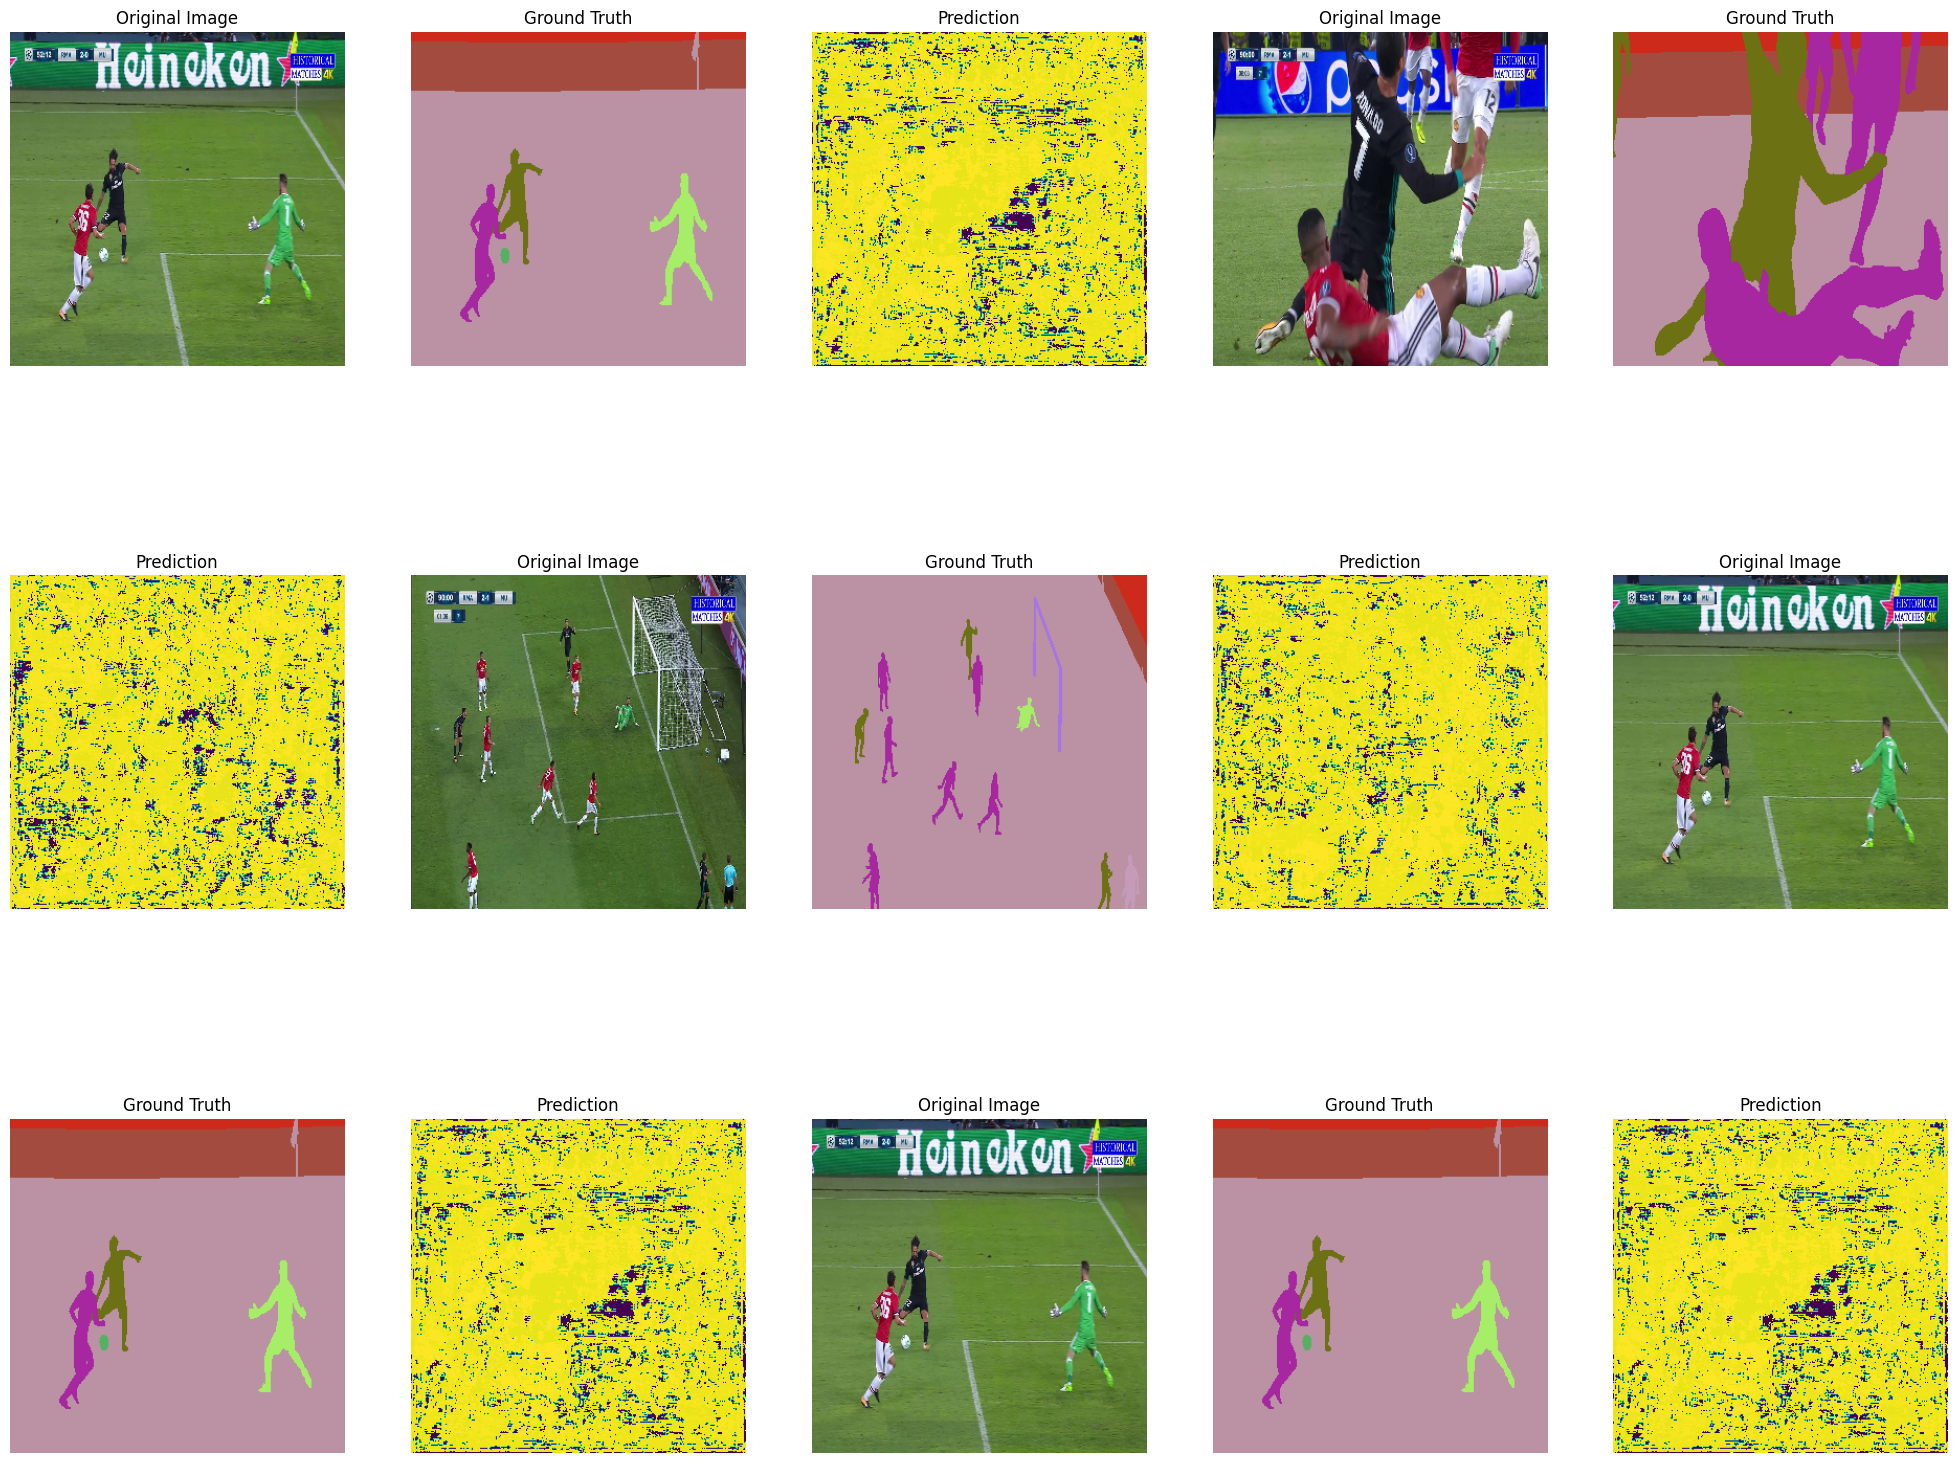

In [16]:
visualize_predictions(model, data_loaders['test'].dataset, num_images=15, device=device)
